<a href="https://colab.research.google.com/github/wdoppenberg/mp-operational-envelope/blob/master/OperationalEnvelope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/wdoppenberg/mp-operational-envelope.git

Cloning into 'mp-operational-envelope'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 55 (delta 16), reused 42 (delta 10), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [2]:
cd mp-operational-envelope

/content/mp-operational-envelope


In [0]:
import numpy as np
from analysis import constants as c, functions as f, components as cmp

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [0]:
def mdot(p, A_t, Gamma, R, T_c):
    """
    Mass flow function.

    Accepts type `np.array` for `p` and `T_c`
    """
    return (p*A_t*Gamma) / np.sqrt(R*T_c)

def p_t(V_0, p_0, m_exit_t, rho):
    """
    Pressure vs time function.
    """
    return (V_0 * p_0) / (V_0 + (m_exit_t/rho))

In [0]:
p_0 = np.arange(1., 2.2, 0.4)*1e5
T_c0 = c.h_vap*c.T_vap0/(c.T_vap0*c.R_vap*np.log(c.p_vap0/p_0)+c.h_vap)
m_0 = p_0*c.A_t*c.Gamma/(np.sqrt(c.R*T_c0))
V_0 = np.arange(0.05, 0.2, 0.05)*c.V_tube

sim_dim = (len(p_0), len(V_0), len(c.t))

m = np.zeros(sim_dim)
p = np.zeros(sim_dim)
temp = np.zeros(sim_dim)

m[:, :, 0], _ = np.meshgrid(m_0, V_0, indexing='ij')
p[:, :, 0], V_0 = np.meshgrid(p_0, V_0, indexing='ij')
p_0 = p[:, :, 0]

T_c = 600

In [63]:
%%time
for ii in range(1,len(c.t)):
    p[:,:,ii] = V_0*p_0/(V_0+temp[:,:,ii-1])
    m[:,:,ii] = mdot(p[:,:,ii-1], c.A_t, c.Gamma, c.R, T_c)
    temp[:,:,ii] = temp[:,:,ii-1]+m[:,:,ii]*c.dt/c.rho

T_vap = c.h_vap*c.T_vap0/(c.T_vap0*c.R_vap*np.log(c.p_vap0/p)+c.h_vap)

CPU times: user 557 ms, sys: 33.7 ms, total: 591 ms
Wall time: 546 ms


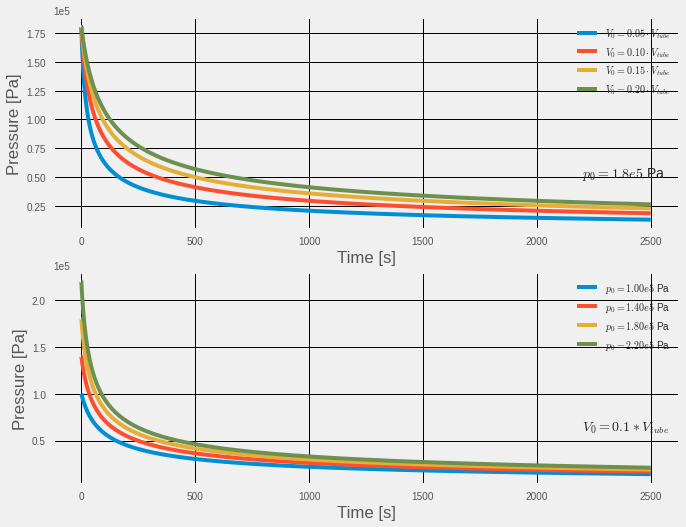

In [81]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2, 1, figsize=(10,8))

for i, p_i in enumerate(p[2,:,:]):
    ax[0].plot(c.t, p_i, label=f'$V_0 = {V_0[0,i]/c.V_tube:.2f}\cdot V_{{tube}}$')

ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Pressure [Pa]')
ax[0].text(2200, 0.5e5, f'$p_0 = {p[2,0,0]/1e5:.1f}e5$ Pa')
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[0].legend()
ax[0].grid(color='k')

for i, p_i in enumerate(p[:,1,:]):
    ax[1].plot(c.t, p_i, label=f'$p_0 = {p[i,0,0]/1e5:.2f}e5$ Pa')

ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Pressure [Pa]')
ax[1].text(2200, 0.6e5, f'$V_0 = {V_0[1,1]/c.V_tube}*V_{{tube}}$')
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[1].legend()
ax[1].grid(color='k')